In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectorMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectorMixin, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.ticker as mtick
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the development set
with open('../data/development_set.pkl', 'rb') as f:
    X_dev_set, y_dev_set = pickle.load(f)
# Load the test set
with open('../data/test_set.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)
# Software metrics_concidered
with open('../data/metrics_concidered.pkl', 'rb') as file:
    metrics_concidered = pickle.load(file)

### DL model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X_dev_set, y_dev_set, test_size=0.1, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [4]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        
        # layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # Xavier initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    
    def forward(self, x):
        x = self.relu(self.batchnorm1(self.layer1(x)))
        x = self.relu(self.batchnorm2(self.layer2(x)))
        x = self.output_layer(x)
        return x

Epoch [1/50], Train Loss: 1.7051, Validation Loss: 1.4682, Validation Accuracy: 0.4146
Epoch [2/50], Train Loss: 1.2784, Validation Loss: 1.3666, Validation Accuracy: 0.4329
Epoch [3/50], Train Loss: 1.1325, Validation Loss: 1.2857, Validation Accuracy: 0.5244
Epoch [4/50], Train Loss: 1.0306, Validation Loss: 1.2558, Validation Accuracy: 0.5610
Epoch [5/50], Train Loss: 0.9665, Validation Loss: 1.2068, Validation Accuracy: 0.5976
Epoch [6/50], Train Loss: 0.9041, Validation Loss: 1.1625, Validation Accuracy: 0.5976
Epoch [7/50], Train Loss: 0.8414, Validation Loss: 1.1229, Validation Accuracy: 0.6159
Epoch [8/50], Train Loss: 0.8136, Validation Loss: 1.1033, Validation Accuracy: 0.6098
Epoch [9/50], Train Loss: 0.7678, Validation Loss: 1.1054, Validation Accuracy: 0.6037
Epoch [10/50], Train Loss: 0.7482, Validation Loss: 1.1238, Validation Accuracy: 0.5793
Epoch [11/50], Train Loss: 0.7009, Validation Loss: 1.1035, Validation Accuracy: 0.5793
Epoch [12/50], Train Loss: 0.6817, Valida

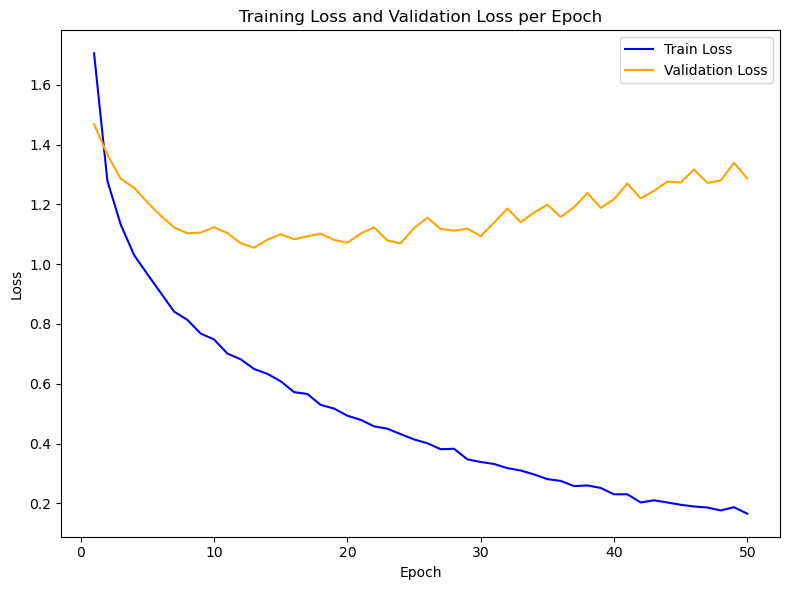

In [5]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features
hidden_size = 600  # Hidden layer size
output_size = 5  # Number of classes

model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 1024
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = [] 
val_losses = []
val_accuracies = []  
best_val_accuracy = 0.0  
best_model_weights = None 

# Training loop
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate the training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # Evaluate the model on the valset
    model.eval()  
    with torch.no_grad(): 
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)  
        val_losses.append(val_loss.item())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor, val_predictions)
        # Check if best val accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict() 
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plot train curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss per Epoch')
plt.legend()
# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig('dl_training_curve.png', dpi=600, bbox_inches='tight')

In [6]:
# Load the best model weights
model.load_state_dict(best_model_weights)
# Run inference on test
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test_tensor, test_predictions)
    print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

Test Accuracy (Best Model): 0.6439


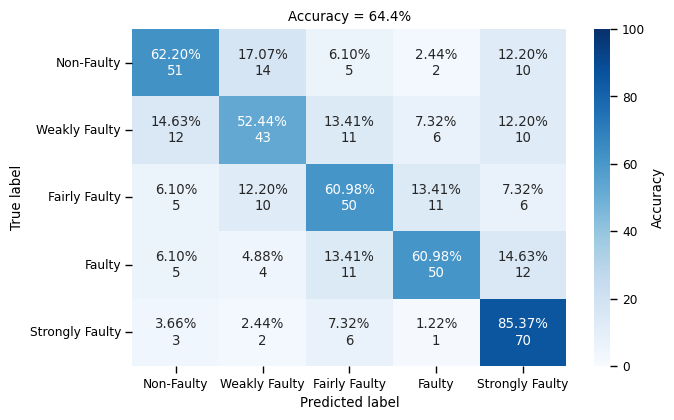

In [7]:
# Label mapping
label_to_int = {
    'Non-Faulty': 0,
    'Weakly Faulty': 1,
    'Fairly Faulty': 2,
    'Faulty': 3,
    'Strongly Faulty': 4
}

def draw_confusion_matrix(ground_truth, predicted):
    # Compute confusion matrix
    matrix = confusion_matrix(ground_truth, predicted)
    percentages = (matrix.T / matrix.sum(axis=1)).T
    # Set cell format
    flattened_counts = [value for value in matrix.flatten()]
    flattened_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
    labels = [f"{percentage}\n{value}" for value, percentage in zip(flattened_counts, flattened_percentages)]
    labels = np.asarray(labels).reshape(matrix.shape[0], matrix.shape[1])
    # Formatting
    percentDataframe = pd.DataFrame(percentages * 100, 
                                    columns=[key for key in label_to_int.keys()],
                                    index=[key for key in label_to_int.keys()])
    
    # Plot
    sns.set_context('paper', font_scale=1.0)
    width = 7
    height = width / 1.6
    plt.figure(figsize=(width, height))
    ax = plt.axes()
    # Heatmap of the confusion matrix
    sns.heatmap(percentDataframe, annot=labels, fmt='', cmap='Blues', ax=ax, vmin=0, vmax=100, cbar_kws={'label': 'Accuracy'})
    ax.yaxis.set_tick_params(rotation=0)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.title.set_text('Accuracy = {0:.1%}'.format(sum(1 for x, y in zip(ground_truth, predicted) if x == y) / len(ground_truth)))
    #plt.show()
    plt.savefig('dl_confusion_matrix.png', dpi=600, bbox_inches='tight')
    
    
#y_pred = model.predict(X_test)
draw_confusion_matrix(y_test, test_predictions) 

In [8]:
def bootstrap_evaluation(X_test, y_test, n_iterations=1000, random_seed=0):
    """
    Run bootstrap evaluation on the specified model and return performance metrics with confidence intervals.

    Returns:
        dict: Dictionary with mean and std of precision, recall, and accuracy.
    """
    
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    for i in range(n_iterations):
        # Resample with replacement
        X_resampled, y_resampled = resample(X_test, y_test, random_state=random_seed + i)
        # Predict
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_resampled, dtype=torch.float32)
            test_outputs = model(X_test_tensor)
            _, y_pred_resampled = torch.max(test_outputs, 1)
        # Compute metrics
        precision, recall, _, _ = precision_recall_fscore_support(
            y_resampled, y_pred_resampled, average='weighted'
        )
        accuracy = accuracy_score(y_resampled, y_pred_resampled)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)

    # Compute errors
    results = {
        'precision_mean': np.mean(precision_scores),
        'precision_std': np.std(precision_scores),
        'recall_mean': np.mean(recall_scores),
        'recall_std': np.std(recall_scores),
        'accuracy_mean': np.mean(accuracy_scores),
        'accuracy_std': np.std(accuracy_scores),
    }

    print(f"  Weighted Precision: {results['precision_mean'] * 100:.1f}% ± {results['precision_std'] * 100:.1f}%")
    print(f"  Weighted Recall:    {results['recall_mean'] * 100:.1f}% ± {results['recall_std'] * 100:.1f}%")
    print(f"  Accuracy:           {results['accuracy_mean'] * 100:.1f}% ± {results['accuracy_std'] * 100:.1f}%")

    return results

results = bootstrap_evaluation(X_test, y_test)

  Weighted Precision: 64.8% ± 2.4%
  Weighted Recall:    64.4% ± 2.4%
  Accuracy:           64.4% ± 2.4%
